# Chapter 15: Vapor-Liquid Equilibria (Flash Calculations)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will write a script to perform an **Isothermal Flash Calculation**.
Given a fluid mixture with overall composition $z_i$, Temperature $T$, and Pressure $P$, we want to determine:
1.  **Vapor Fraction ($n_V$):** How much of the mole lies in the gas phase?
2.  **Liquid Fraction ($n_L$):** How much lies in the liquid phase?
3.  **Compositions:** What are the mole fractions of the gas ($y_i$) and liquid ($x_i$)?

**The Physics:**
The equilibrium is governed by the **Equilibrium Ratio ($K_i$)**:
$$K_i = \frac{y_i}{x_i}$$

The material balance combines with the equilibrium constraint to form the **Rachford-Rice Equation**:
$$\sum_{i=1}^{n} \frac{z_i (K_i - 1)}{1 + n_V (K_i - 1)} = 0$$

Where $n_V$ (often denoted as $V/F$) is the Vapor Fraction. We must solve this equation numerically to find the root $n_V$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# --- 1. COMPONENT PROPERTIES ---
# We need Critical Pressure (Pc), Critical Temp (Tc), and Acentric Factor (omega)
# to estimate K-values.
# Units: Tc (Rankine), Pc (psia)

components = {
    'Component': ['C1', 'C2', 'C3', 'iC4', 'nC4', 'iC5', 'nC5', 'C6'],
    'z':         [0.50, 0.10, 0.15, 0.05,  0.05,  0.05,  0.05,  0.05], # Feed Composition
    'Tc':        [343.0, 549.6, 665.7, 734.1, 765.3, 828.8, 845.4, 913.4],
    'Pc':        [667.8, 706.6, 616.3, 529.1, 550.7, 490.4, 488.6, 436.9],
    'omega':     [0.011, 0.099, 0.152, 0.183, 0.199, 0.227, 0.251, 0.299]
}

df_comp = pd.DataFrame(components)

# Normalize z just in case user input doesn't sum to 1
df_comp['z'] = df_comp['z'] / df_comp['z'].sum()

print("--- Feed Composition & Properties ---")
print(df_comp[['Component', 'z', 'Tc', 'Pc']])

--- Feed Composition & Properties ---
  Component     z     Tc     Pc
0        C1  0.50  343.0  667.8
1        C2  0.10  549.6  706.6
2        C3  0.15  665.7  616.3
3       iC4  0.05  734.1  529.1
4       nC4  0.05  765.3  550.7
5       iC5  0.05  828.8  490.4
6       nC5  0.05  845.4  488.6
7        C6  0.05  913.4  436.9


## 1. Estimating K-Values (Wilson's Correlation)

In a rigorous simulation, $K_i$ is calculated iteratively using Fugacity coefficients ($\phi_i$) from an EOS (like Peng-Robinson).
However, for this exercise, we will use the **Wilson Correlation**, which provides a very good initial estimate for low-to-moderate pressures.

$$K_i = \frac{P_{ci}}{P} \exp \left( 5.37(1 + \omega_i) \left( 1 - \frac{T_{ci}}{T} \right) \right)$$

In [2]:
def calc_K_wilson(P, T, Pc, Tc, omega):
    """
    Calculates K-values using Wilson's empirical correlation.
    Args:
        P: System Pressure (psia)
        T: System Temperature (Rankine)
        Pc, Tc, omega: Component properties (Arrays or Series)
    """
    term1 = Pc / P
    term2 = 5.37 * (1 + omega) * (1 - (Tc / T))
    K = term1 * np.exp(term2)
    return K

# Let's test it at standard conditions
P_sys = 500  # psia
T_sys = 160 + 460 # Rankine (160 F)

df_comp['K'] = calc_K_wilson(P_sys, T_sys, df_comp['Pc'], df_comp['Tc'], df_comp['omega'])

print(f"--- K-Values at {P_sys} psi, {T_sys} R ---")
print(df_comp[['Component', 'K']])

--- K-Values at 500 psi, 620 R ---
  Component          K
0        C1  15.103840
1        C2   2.762061
2        C3   0.781250
3       iC4   0.328725
4       nC4   0.243572
5       iC5   0.106630
6       nC5   0.084980
7        C6   0.032195


## 2. The Rachford-Rice Solver

We need to find the vapor fraction $n_V$ such that the function equals zero:
$$f(n_V) = \sum \frac{z_i (K_i - 1)}{1 + n_V (K_i - 1)} = 0$$

**Constraints:**
* If all $K_i > 1$, the fluid is Superheated Vapor ($n_V = 1$).
* If all $K_i < 1$, the fluid is Subcooled Liquid ($n_V = 0$).
* Otherwise, $0 < n_V < 1$.

We will use `scipy.optimize.brentq`, a robust root-finding algorithm.

In [3]:
def solve_rachford_rice(z, K):
    """
    Solves for Vapor Fraction (nv) given Feed (z) and K-values.
    """
    # 1. Define the Objective Function
    def rachford_rice_func(nv):
        # f(nv) = sum [ z * (K-1) / (1 + nv(K-1)) ]
        numerator = z * (K - 1)
        denominator = 1 + nv * (K - 1)
        return np.sum(numerator / denominator)
    
    # 2. Check Phase Stability (Do we even have two phases?)
    # Evaluate at nv=0 (Bubble Point check) and nv=1 (Dew Point check)
    f_0 = rachford_rice_func(0) # Should be > 0 for two-phase
    f_1 = rachford_rice_func(1) # Should be < 0 for two-phase
    
    if f_0 <= 0:
        return 0.0 # Subcooled Liquid (No Gas)
    elif f_1 >= 0:
        return 1.0 # Superheated Vapor (All Gas)
    
    # 3. Solve for Root between 0 and 1
    nv_solution = brentq(rachford_rice_func, 0, 1)
    return nv_solution

# --- EXECUTE FLASH ---
nv = solve_rachford_rice(df_comp['z'].values, df_comp['K'].values)
nl = 1 - nv

print(f"--- Flash Results ---")
print(f"Vapor Fraction (nv): {nv:.4f}")
print(f"Liquid Fraction (nl): {nl:.4f}")

--- Flash Results ---
Vapor Fraction (nv): 0.7631
Liquid Fraction (nl): 0.2369


## 3. Calculating Phase Compositions

Once we have $n_V$, we can back-calculate the composition of the liquid ($x_i$) and vapor ($y_i$) for each component:

$$x_i = \frac{z_i}{1 + n_V (K_i - 1)}$$

$$y_i = K_i x_i$$

Check Sums -> x: 1.0000, y: 1.0000

--- Detailed Phase Composition ---
  Component     z          K         x         y
0        C1  0.50  15.103840  0.042508  0.642035
1        C2  0.10   2.762061  0.042651  0.117805
2        C3  0.15   0.781250  0.180056  0.140669
3       iC4  0.05   0.328725  0.102510  0.033698
4       nC4  0.05   0.243572  0.118265  0.028806
5       iC5  0.05   0.106630  0.157095  0.016751
6       nC5  0.05   0.084980  0.165695  0.014081
7        C6  0.05   0.032195  0.191220  0.006156


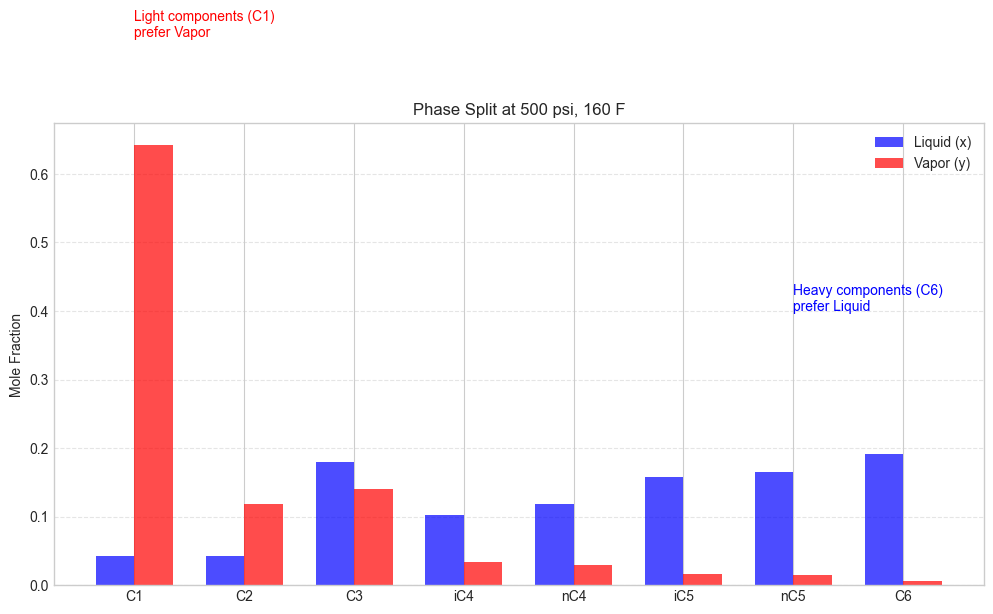

In [4]:
# Calculate x and y
df_comp['x'] = df_comp['z'] / (1 + nv * (df_comp['K'] - 1))
df_comp['y'] = df_comp['K'] * df_comp['x']

# Verification (Sum should be 1.0)
sum_x = df_comp['x'].sum()
sum_y = df_comp['y'].sum()

print(f"Check Sums -> x: {sum_x:.4f}, y: {sum_y:.4f}")
print("\n--- Detailed Phase Composition ---")
print(df_comp[['Component', 'z', 'K', 'x', 'y']])

# --- VISUALIZATION ---
# Let's plot the "Split"
ind = np.arange(len(df_comp))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(ind - width/2, df_comp['x'], width, label='Liquid (x)', color='blue', alpha=0.7)
rects2 = ax.bar(ind + width/2, df_comp['y'], width, label='Vapor (y)', color='red', alpha=0.7)

ax.set_ylabel('Mole Fraction')
ax.set_title(f'Phase Split at {P_sys} psi, {T_sys-460} F')
ax.set_xticks(ind)
ax.set_xticklabels(df_comp['Component'])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Add "Light vs Heavy" Annotation
plt.text(0, 0.8, 'Light components (C1)\nprefer Vapor', color='red', fontsize=10)
plt.text(6, 0.4, 'Heavy components (C6)\nprefer Liquid', color='blue', fontsize=10)



plt.show()

## Conclusion

We have successfully built a **Flash Calculator**.

* **The Methane Effect:** Notice in the plot how Methane (C1) is dominant in the Vapor phase ($y_{C1} \gg x_{C1}$).
* **The Heptane Effect:** Notice how the heavier components concentrate in the Liquid phase.
* **Algorithm:** This loop (calculate K $\to$ solve Rachford-Rice $\to$ update composition) is exactly what happens inside commercial software like HYSYS, Eclipse, or PVTsim.